# Linking SDG&E utility data with building polygons
This notebook will take Global Building Atlas polygons and link to the nearest SDG&E feeder line.

In [12]:
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import box
from shapely.geometry import MultiLineString
import matplotlib.pyplot as plt
import glob
import os
import folium

In [13]:
# create a bbox  for san diego
bbox = box(-117.259939,32.669123,-117.054289,32.780034)
bbox = gpd.GeoDataFrame(geometry=[bbox], crs="EPSG:4326")

# Read in SDGE line data

In [2]:
sdge_feederlines = gpd.read_file("../../../../capstone/electrigrid/data/utilities/sandiego_grid/lines_sdge.geojson")

In [3]:
sdge_feederlines.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [4]:
# convert to projected crs
sdge_feederlines = sdge_feederlines.to_crs(epsg=4326)

In [14]:
# Clip circuits to bbox
sdge_feederlines = gpd.clip(sdge_feederlines, bbox)
sdge_feederlines.head()

,SUBID,OBJECTID,VOLTAGE,LINE_SEGMENT_NUMBER,ICAWOF_UNIGENERATION,ICAWOF_UNILOAD,ICAWOF_PVGENERATION,OHUG,CIRCUIT_NAME,LABELTEXT,ICAWNOF_UNIGENERATION,ICAWNOF_UNILOAD,ICAWNOF_PVGENERATION,LABELTEXT_ICA,RESTRICTED,ICAWOF_UNIGENERATION_LC,ICAWOF_UNILOAD_LC,ICAWNOF_UNIGENERATION_LC,substations,geometry
95,SWEETWATER,32580779,12,1699876,2.6,0.1,3.2,UG,41,None,2.6,0.1,3.2,Above 2,N,ICA_Voltage,Load_Thermal,ICA_Voltage,SWEETWATER,"MULTILINESTRING ((-117.09619 32.67215, -117.09..."
65,PARADISE,32507484,12,13442,0.0,1.0,0.5,UG,320,None,1.8,1.0,1.8,0,N,ICA_Operation_Flex,Load_Thermal,ICA_Thermal,PARADISE,"MULTILINESTRING ((-117.06866 32.68430, -117.06..."
79,SAMPSON,32503863,12,28169,0.0,2.7,0.0,OH,130,None,2.7,2.7,3.1,0,N,ICA_Operation_Flex,Load_Thermal,ICA_Thermal,SAMPSON,"MULTILINESTRING ((-117.15886 32.70580, -117.15..."
102,WABASH CANYON,32839681,12,1011381,0.1,1.8,0.1,UG,1418,None,0.6,1.8,0.9,Up to 1.00,N,ICA_Operation_Flex,Load_Voltage,ICA_Voltage_Delta,WABASH CANYON,"MULTILINESTRING ((-117.09384 32.72216, -117.09..."
15,CHOLLAS WEST,32503766,12,1845491,-0.1,0.8,0.1,OH,1047,None,2.2,0.8,2.7,0,N,ICA_Operation_Flex,Load_Thermal,ICA_Voltage_Delta,CHOLLAS WEST,"MULTILINESTRING ((-117.06213 32.72974, -117.06..."


# Reading in Building data

In [7]:
path = "../../../../capstone/electrigrid/data/buildings/w120_n35_w115_n30.parquet"
buildings = gpd.read_parquet(path)

In [8]:
buildings.crs

<Geographic 2D CRS: OGC:CRS84>
Name: WGS 84 (CRS84)
Axis Info [ellipsoidal]:
- Lon[east]: Geodetic longitude (degree)
- Lat[north]: Geodetic latitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [15]:
# Convert buildings crs & clip to sdge
buildings = buildings.to_crs(epsg=4326)
buildings_clip = gpd.clip(buildings, bbox)

In [10]:
buildings_clip.head()

,source,id,height,var,region,bbox,geometry
6765229,ms,UnitedStates_023013221_316654,1.634766,0.439866,USA,"{'xmin': -117.09894357258146, 'ymin': 32.55831...","LINESTRING (-117.09894 32.55832, -117.09887 32..."
6765224,ms,UnitedStates_023013221_490549,1.362633,0.110612,USA,"{'xmin': -117.09625646331463, 'ymin': 32.55830...","LINESTRING (-117.09625 32.55832, -117.09617 32..."
6765223,ms,UnitedStates_023013221_588276,1.561188,0.109693,USA,"{'xmin': -117.09635795268954, 'ymin': 32.55831...","LINESTRING (-117.09636 32.55832, -117.09628 32..."
7029433,ms,UnitedStates_023013221_371966,4.773494,0.872164,USA,"{'xmin': -117.09219278793009, 'ymin': 32.56608...","LINESTRING (-117.09219 32.56623, -117.09210 32..."
7029968,ms,UnitedStates_023013221_180009,7.939373,1.348022,USA,"{'xmin': -117.10344277229454, 'ymin': 32.56920...","LINESTRING (-117.10327 32.56938, -117.10321 32..."


# Plot buildings and grid together

<Axes: >

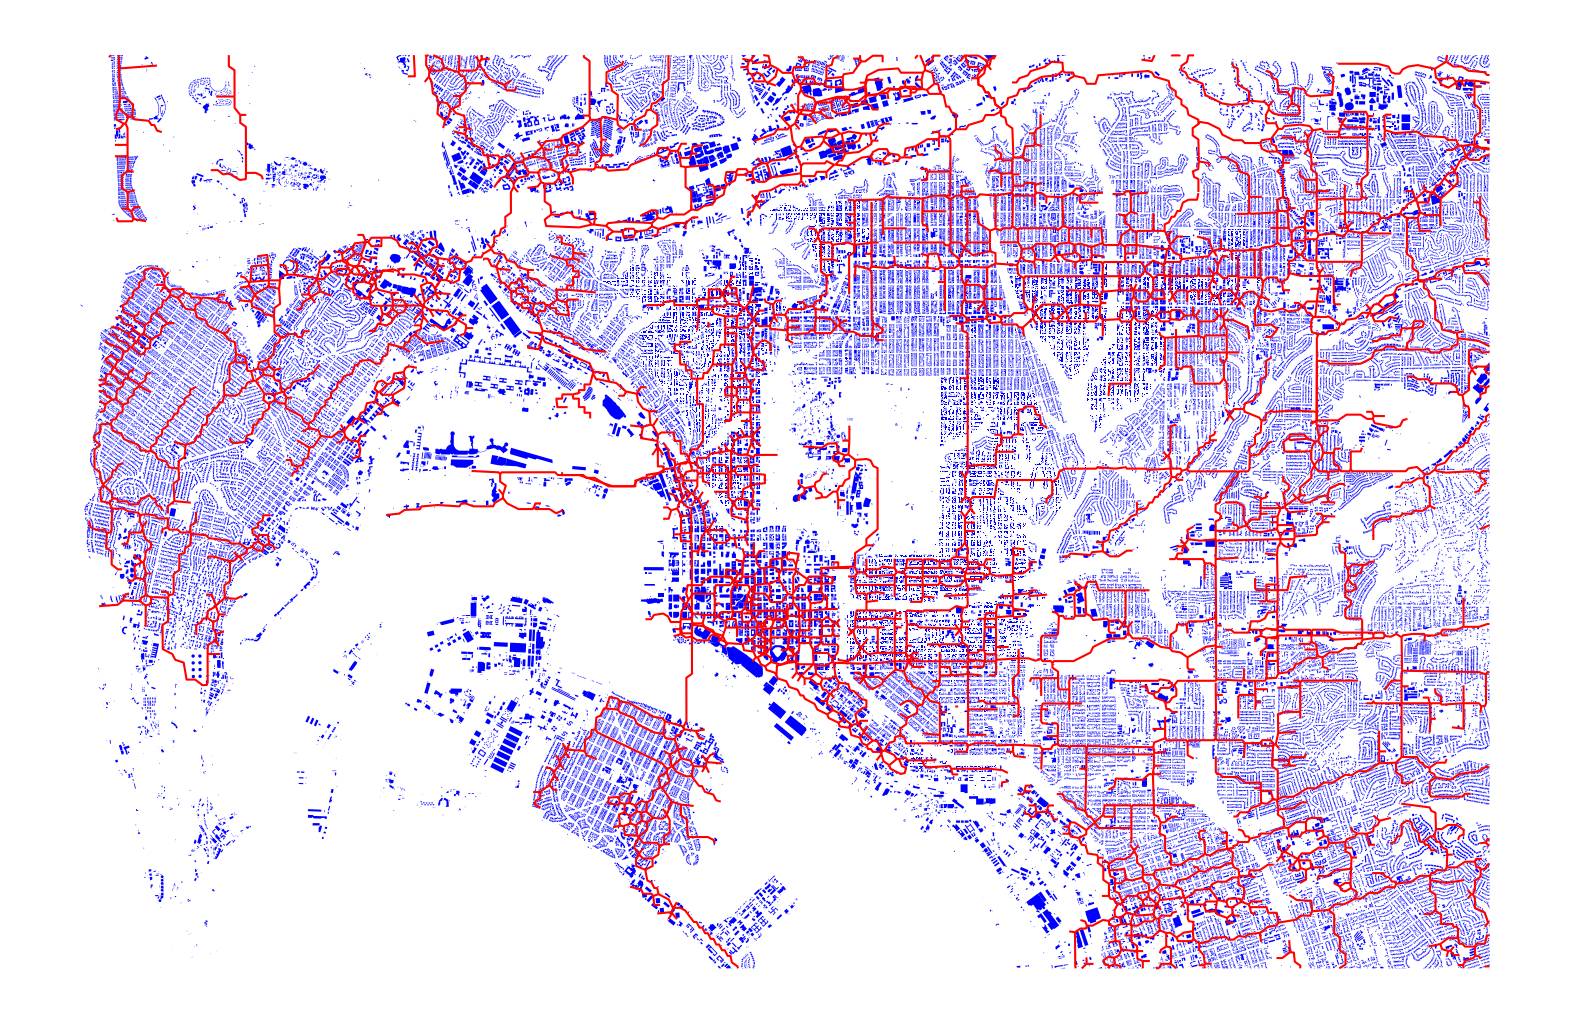

In [16]:
fig, ax = plt.subplots(figsize=(20, 20))

ax.axis('off')

buildings_clip.plot(ax=ax, color='blue')

sdge_feederlines.plot(ax=ax, color='red')

# Link data

In [ ]:
# Convert building footprints to centroid of building
buildings_clip['geometry'] = buildings_clip.centroid

In [ ]:
# data_linked = gpd.sjoin_nearest(buildings_clip, sce_segments_table[['CIRCUIT', 'section_id', 'ica_overall_load', 'substation_name', 'geometry']], how='left', distance_col='dist_to_line_m')